In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [105]:
data = pd.read_csv("./CreditPrediction.csv")

data = data.drop(columns=['Unnamed: 19', 'CLIENTNUM'])

# This is wrong
#data = data[data['Customer_Age'] <= 100]
#data = data[data['Total_Revolving_Bal'] != 0]

print(data.shape)
data.head()

(10167, 18)


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061
1,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105
2,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000
3,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760
4,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000


In [106]:
education_order = {
    'Uneducated': 1,
    'High School': 2,
    'College': 3,
    'Graduate': 4,
    'Post-Graduate': 5,
    'Doctorate': 6
}

income_order = {
    'Less than $40K': 1,
    '$40K - $60K': 2,
    '$60K - $80K': 3,
    '$80K - $120K': 4,
    '$120K +': 5
}

card_category_order = {
    'Blue': 1,
    'Silver': 2,
    'Gold': 3,
    'Platinum': 4
}

# Map the ordered numbers to the respective columns
data['Education_Level'] = data['Education_Level'].map(education_order)
data['Income_Category'] = data['Income_Category'].map(income_order)
data['Card_Category'] = data['Card_Category'].map(card_category_order)

In [107]:
X = data.drop(columns=['Credit_Limit'])
y = data['Credit_Limit']

def preprocess():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    
    # Define numerical and categorical columns
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns

    encoders = {col: LabelEncoder() for col in categorical_cols}
    for col in categorical_cols:
        X_train[col] = encoders[col].fit_transform(X_train[col].astype(str))
        X_test[col] = encoders[col].transform(X_test[col].astype(str))
    
    numerical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='median')),
        ('imputer', KNNImputer(n_neighbors=13)),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('imputer', KNNImputer(n_neighbors=13)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return (X_train, X_test, y_train, y_test)

In [108]:
def run(model, rep=1):
    mse_table = []
    rmse_table = []
    mae_table = []
    r2_table = []
    time = 0

    for _ in range(rep):
        X_train, X_test, y_train, y_test = preprocess()
        
        start = timeit.default_timer()
        model.fit(X_train, y_train)
        end = timeit.default_timer()
        
        y_pred = model.predict(X_test)

        mse_table.append(mean_squared_error(y_test, y_pred))
        rmse_table.append(mean_squared_error(y_test, y_pred, squared=False))
        mae_table.append(mean_absolute_error(y_test, y_pred))
        r2_table.append(r2_score(y_test, y_pred))
        
        time += end - start

    mse = sum(mse_table) / rep
    rmse = sum(rmse_table) / rep
    mae = sum(mae_table) / rep
    r2 = sum(r2_table) / rep
    time /= rep
    
    print(f'MSE:\t {round(mse, 2)}')
    print(f'RMSE:\t {round(rmse, 2)}')
    print(f'MAE:\t {round(mae, 2)}')
    print(f'R2:\t {round(r2, 6)}')
    print(f'Time:\t {round(time, 6)} seconds')
    if (rep > 1):
        plt.scatter(range(len(mse_table)), mse_table)
        plt.show()
        plt.scatter(range(len(r2_table)), r2_table)
        plt.show()

In [109]:
model = DecisionTreeRegressor(random_state=10)
run(model)

MSE:	 17415056.67
RMSE:	 4173.14
MAE:	 1568.49
R2:	 0.785189
Time:	 0.051672 seconds


In [110]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=2, min_samples_split=10, random_state=10)
run(model)

MSE:	 9984254.77
RMSE:	 3159.79
MAE:	 1247.11
R2:	 0.882012
Time:	 2.216454 seconds


In [111]:
model = GradientBoostingRegressor(n_estimators=400, random_state=10)
run(model)

MSE:	 9418189.03
RMSE:	 3068.91
MAE:	 1491.53
R2:	 0.882244
Time:	 4.286913 seconds


In [112]:
model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.02, subsample=0.62, random_state=10)
run(model)

MSE:	 10750213.92
RMSE:	 3278.75
MAE:	 1289.45
R2:	 0.869104
Time:	 0.29793 seconds


In [113]:
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=2, min_samples_split=5),
    GradientBoostingRegressor(n_estimators=400),
    XGBRegressor(n_estimators=500, max_depth=6, eta=0.02, subsample=0.62)
]

DecisionTreeRegressor
MSE:	 19292970.73
RMSE:	 4389.12
MAE:	 1665.95
R2:	 0.766364
Time:	 0.054564 seconds


/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecation

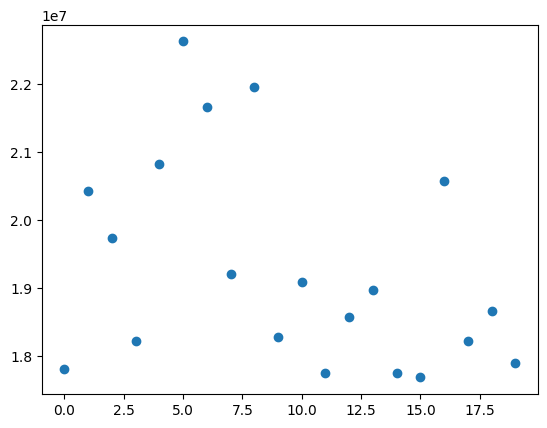

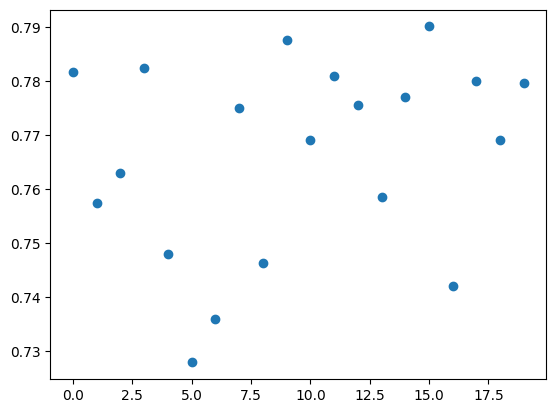

In [114]:
print('DecisionTreeRegressor')
run(models[0], 20)

RandomForestRegressor
MSE:	 9775703.58
RMSE:	 3125.29
MAE:	 1248.23
R2:	 0.881528
Time:	 2.33963 seconds


/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecation

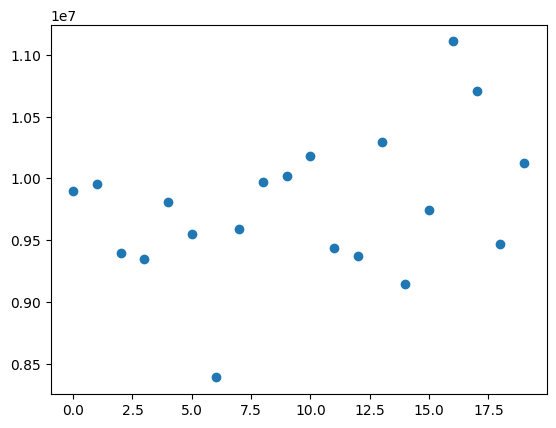

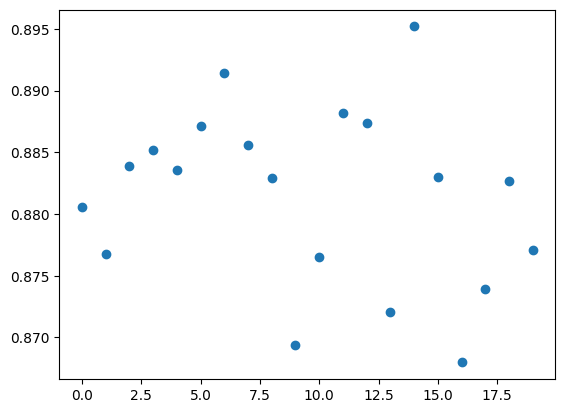

In [115]:
print('RandomForestRegressor')
run(models[1], 20)

GradientBoostingRegressor
MSE:	 9713148.83
RMSE:	 3115.63
MAE:	 1492.5
R2:	 0.882339
Time:	 3.831523 seconds


/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecation

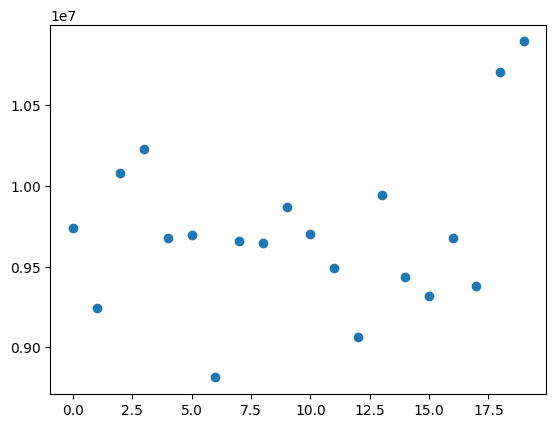

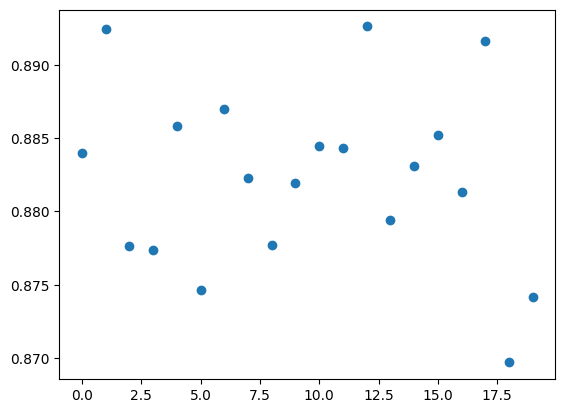

In [116]:
print('GradientBoostingRegressor')
run(models[2], 20)

XGBRegressor
MSE:	 9489646.07
RMSE:	 3079.32
MAE:	 1208.93
R2:	 0.883971
Time:	 0.72035 seconds


/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecation

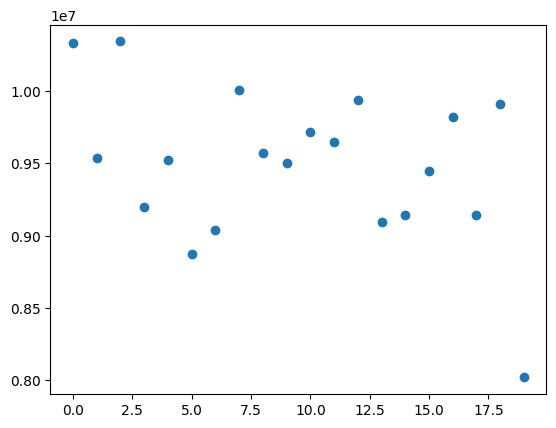

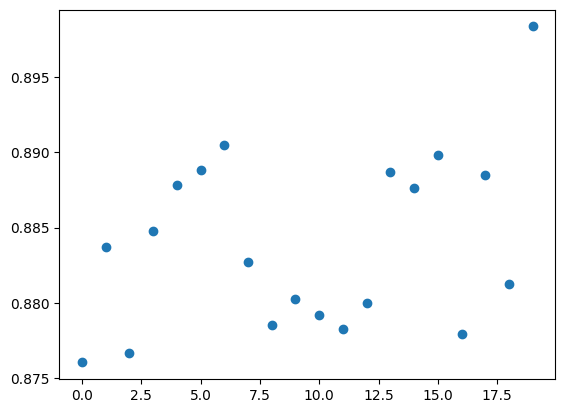

In [117]:
print('XGBRegressor')
run(models[3], 20)

In [118]:
def best_xgb():
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
    }
    
    # Define the GridSearchCV with increased CV folds
    grid_search = GridSearchCV(estimator=XGBRegressor(random_state=10), param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', verbose=2)
    
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Train the model with the best parameters
    best_xgb_model = XGBRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        random_state=10
    )
    
    best_xgb_model.fit(X_train, y_train)
    y_pred = best_xgb_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Best Parameters: {best_params}")
    print(f"Best CV Score: {best_score}")
    print(f"Test MSE: {mse}")
    print(f"Test R²: {r2}")

best_xgb()

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best CV Score: 0.8823581313482842
Test MSE: 10481859.659640392
Test R²: 0.8718810807116777
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=  11.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=1.0; total time=   7.6s
[CV] END colsample_bytree=0.7